In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def detect_lines(img, threshold1 = 10, threshold2 = 20, apertureSize = 3, minLineLength = 800, maxLineGap = 100):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1 = threshold1, threshold2 = threshold2, apertureSize = apertureSize) # detect edges
    lines = cv2.HoughLinesP(
                    edges,
                    1,
                    np.pi/180,
                    100,
                    minLineLength = minLineLength,
                    maxLineGap = maxLineGap,
            ) # detect lines
    return lines

In [22]:
def draw_lines(img,lines, color = (0,255,0)):
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), color, 2)
    plt.imshow(img)

In [4]:
def get_slopes_intercepts(lines):
    slopes = []
    intercepts = []
    for line in lines:
        x1,y1,x2,y2 = line[0]
        slope = (y2-y1)/(x2-x1)
        inverse_slope = (x2-x1)/(y2-y1)
        intercept = x1 - y1*inverse_slope
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts

In [50]:
def detect_lanes(lines):
    # group lines based on slope
    slopes,intercepts = get_slopes_intercepts(lines)
    linesGroup = []
    for i in range(len(lines)):
        if (i == 0):
            linesGroup.append([lines[i]])
        else:
            slope = slopes[i]
            added = False 
            for group in linesGroup:
                x1,y1,x2,y2 = group[0][0]
                slope2 = (y2-y1)/(x2-x1)
                
                if (np.abs(1.0-slope/slope2) < 0.05): # error within 5%
                    group.append(lines[i])
                    added = True
            if (not added):
                linesGroup.append([lines[i]])
    # print (len(linesGroup))
    
    # create singular line from a group of lines
    lessLines = []
    for group in linesGroup:
        x1,y1,x2,y2 = float('inf'),float('inf'),float('-inf'),float('-inf')
        for line in group:
            l = line[0]
            if (l[0] < x1 and l[1] < y1):
                x1,y1 = l[0],l[1]
            if (l[2] > x2 and l[3] > y2):
                x2,y2 = l[2],l[3]
        lessLines.append(np.array([[x1,y1,x2,y2]]))
    
    # sort based on slope
    # group based on lanes
    lanes = []
    slopes, intercepts = get_slopes_intercepts(lessLines)
    sortSlopes = slopes
    # slopes.sort()
    # intercepts.sort()
    print(intercepts)
    print (slopes)
    print (lessLines)
    sortedLines = []
    for i in range(len(lessLines)):
        for j in range(len(lessLines)):
            pass

    for i in range(1, len(lessLines)-1):
        line = lessLines[i]
        slope = slopes[i]
        if (np.abs(1.0-slope/slopes[i-1]) < np.abs(1.0-slope/slopes[i+1])):
            lanes.append([lessLines[i-1],lessLines[i]])
        else:
            lanes.append([lessLines[i],lessLines[i+1]])
        i += 1

    
    return lessLines


In [6]:
def draw_lanes(img, lanes):
    pass

[np.float64(-2959.789473684211), np.float64(-5666.076923076923), np.float64(3360.5405405405404), np.float64(2244.012486992716), np.float64(1950.66137040715), np.float64(19087.199999999997)]
[np.float64(0.1958762886597938), np.float64(0.12491992312620115), np.float64(-0.5543071161048689), np.float64(-1.7315315315315316), np.float64(-4.01195219123506), np.float64(-0.05291005291005291)]
[array([[2074,  986, 3820, 1328]], dtype=int32), array([[2259,  990, 3820, 1185]], dtype=int32), array([[   5, 1860, 1073, 1268]], dtype=int32), array([[1011, 2135, 1566, 1174]], dtype=int32), array([[1419, 2133, 1670, 1126]], dtype=int32), array([[2871,  858, 3816,  808]], dtype=int32)]
[array([[2074,  986, 3820, 1328]], dtype=int32), array([[2259,  990, 3820, 1185]], dtype=int32), array([[   5, 1860, 1073, 1268]], dtype=int32), array([[1011, 2135, 1566, 1174]], dtype=int32), array([[1419, 2133, 1670, 1126]], dtype=int32), array([[2871,  858, 3816,  808]], dtype=int32)]


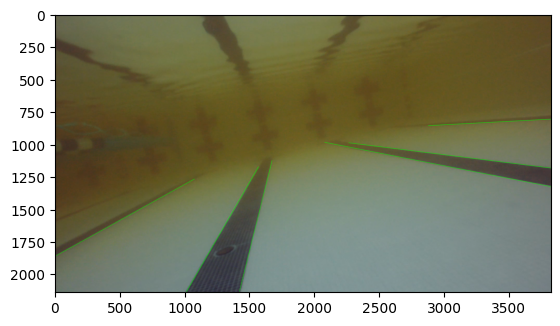

In [51]:
img = cv2.imread("Image.png")
lines = detect_lines(img,minLineLength = 900)
slopes, intercepts = get_slopes_intercepts(lines)
newLines = detect_lanes(lines)
print (newLines)
# print (lines)
# # print (slopes)
# # print (len(lines))
draw_lines(img,newLines)